Preparing Apple Stock Data

[*********************100%***********************]  1 of 1 completed


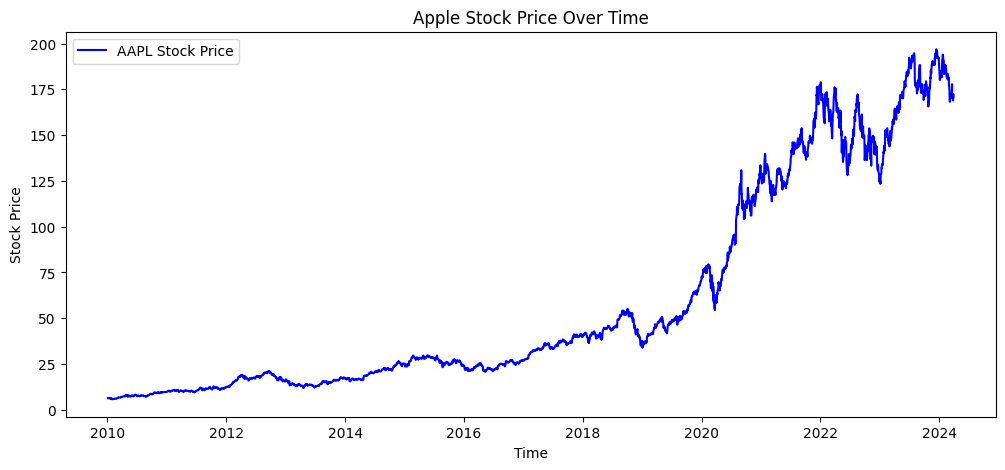

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download Apple stock data
ticker = "AAPL"
data = yf.download(ticker, start="2010-01-01", end="2024-04-01")

# Keep only "Close" prices
data = data[['Close']]
data.rename(columns={'Close': 'Price'}, inplace=True)

# Plot stock prices
plt.figure(figsize=(12,5))
plt.plot(data, label="AAPL Stock Price", color="blue")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Apple Stock Price Over Time")
plt.legend()
plt.show()


Data Preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

# Scale prices between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Price'] = scaler.fit_transform(data[['Price']])

# Convert time series to sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 50  # Number of past days to use for prediction
X, y = create_sequences(data['Scaled_Price'].values, seq_length)

# Split into training and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for Transformer input
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (2826, 50, 1), Test shape: (707, 50, 1)


Building the GPT-Like Transformer Model

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Flatten

# Transformer Block
def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feedforward
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)

    return LayerNormalization(epsilon=1e-6)(x + x_ff)

# Build Transformer model
def build_gpt_stock_model(input_shape):
    inputs = Input(shape=input_shape)

    x = transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128)
    x = transformer_block(x, head_size=64, num_heads=4, ff_dim=128)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    model = Model(inputs, x)
    return model

# Create and compile the model
model = build_gpt_stock_model((seq_length, 1))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50, 1)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 50, 1)          │          1,793 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 50, 1)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 50, 1)          │              2 │ dropout_1[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 128)        │            256 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 50, 1)          │            129 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 50, 1)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 50, 1)          │              2 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 50, 1)          │          1,793 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 50, 1)          │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 50, 1)          │              2 │ dropout_4[0][0]        │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 128)        │            256 │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 50, 128)        │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 50, 1)          │            129 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 50, 1)          │              0 │ layer_normalization_2… │
│                           │                        │                │ dense_3[0][0]          │
├──────────────────────

 Total params: 11,021 (43.05 KB)

 Trainable params: 11,021 (43.05 KB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [8]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50, batch_size=32, verbose=1)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 0.0394 - val_loss: 0.5407
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0279 - val_loss: 0.4760
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0251 - val_loss: 0.4483
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0239 - val_loss: 0.4397
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0233 - val_loss: 0.4368
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0245 - val_loss: 0.4375
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0249 - val_loss: 0.4395
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0248 - val_loss: 0.4368
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0235 - val_loss: 0.4368
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0244 - val_loss: 0.4356
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0242 - val_loss: 0.4368
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0

Evaluate and Predict Future Prices

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


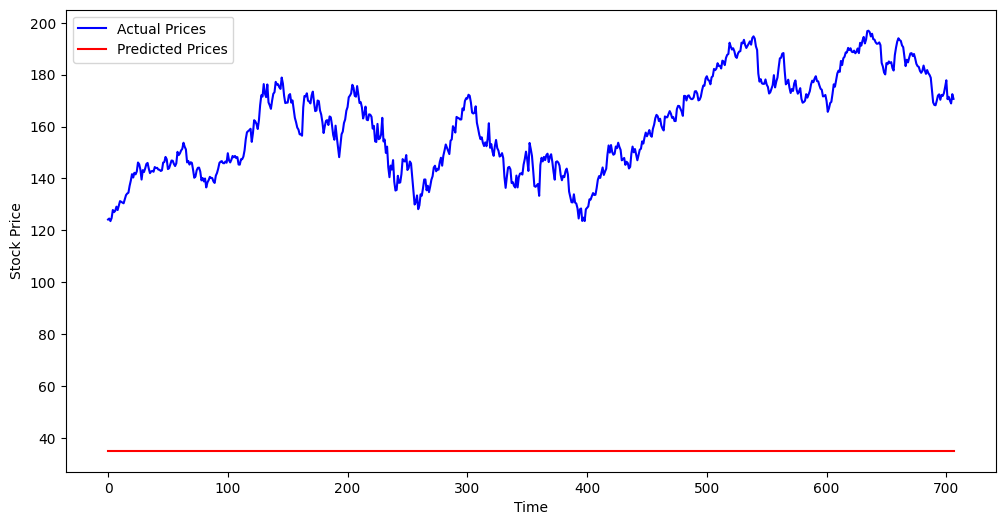

In [9]:
# Make predictions
predictions = model.predict(X_test)

# Rescale to original price range
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices", color='blue')
plt.plot(predictions, label="Predicted Prices", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
